# Neural Network Implementation from Scratch 
> for this check the model.py file

# Sanity Check

## The XOR Problem

In [1]:
# imports

from model import ReLU , Sigmoid , Tanh , Identity , Linear  , Model , train_model , MSELoss , BCELoss
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:
# XOR dataset
class XORDataset:
    """Dataset class for XOR problem."""
    
    def __init__(self):
        self.data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
        self.labels = np.array([[0], [1], [1], [0]], dtype=float)  # XOR truth table
        self.indices = np.arange(len(self.data))
    
    def shuffle(self):
        # Set seed for reproducible shuffling
        np.random.seed(42)
        np.random.shuffle(self.indices)
    
    def get_all_samples(self):
        self.shuffle()
        return self.data[self.indices], self.labels[self.indices]
    
    def get_batch(self, batch_size):
        # Set seed for reproducible batch selection
        np.random.seed(42)
        batch_indices = np.random.choice(len(self.data), batch_size, replace=True)
        return self.data[batch_indices], self.labels[batch_indices]
    
    def __len__(self):
        return len(self.data)

In [7]:
def test_xor_with_arch(layers, loss_fn, learning_rate=0.5 ,run_name="sample_run"):
    for layer in layers:
        layer.learning_rate = learning_rate

    model = Model(layers, loss_fn)
    dataset = XORDataset()
    
    results = train_model(
        model, dataset, 
        batch_size=4,
        grad_accumulation_steps=1,
        max_epochs=5000,  
        patience=500, 
        relative_loss_threshold=0.00001,  
        run_name=run_name,
        save_model=False,  
        use_wandb=False
    )
    
    # finding accuracy
    test_input = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    test_output = np.array([[0], [1], [1], [0]])
    predictions = model.predict(test_input)
    threshold = 0.5
    predicted_labels = (predictions > threshold).astype(int)
    accuracy = np.mean(predicted_labels == test_output)
    
    return {
        
        'accuracy': accuracy,
        'final_loss': results['final_loss'],
        'epochs': results['total_epochs'],
        'parameters': results['model_parameters']
    }

Starting training: sample_run
Training completed: 5000 epochs, 20000 samples
Final loss: 0.002702


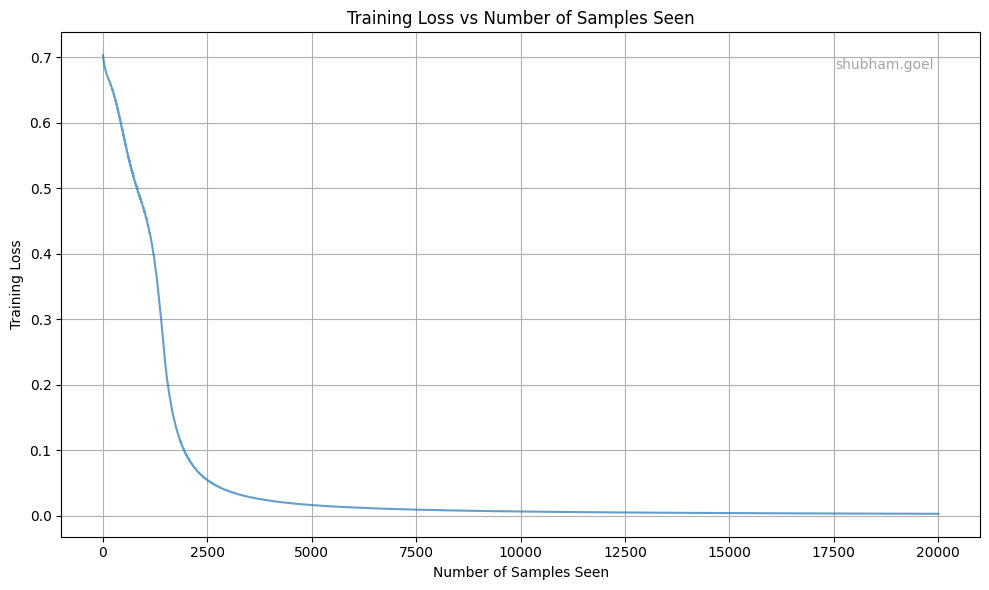

Test 1: {'accuracy': np.float64(1.0), 'final_loss': np.float64(0.0027017883481038766), 'epochs': 5000, 'parameters': 13}
Starting training: sample_run
Training completed: 5000 epochs, 20000 samples
Final loss: 0.001860


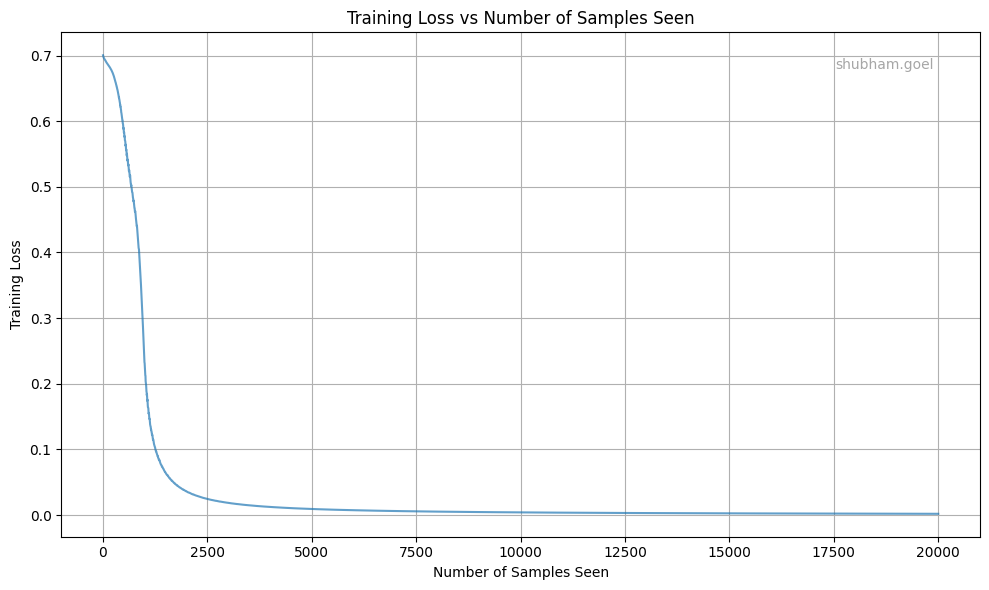

Test 2: {'accuracy': np.float64(1.0), 'final_loss': np.float64(0.001859866530708227), 'epochs': 5000, 'parameters': 25}
Starting training: sample_run
Early stopping at epoch 4841
Training completed: 4842 epochs, 19368 samples
Final loss: 0.000000


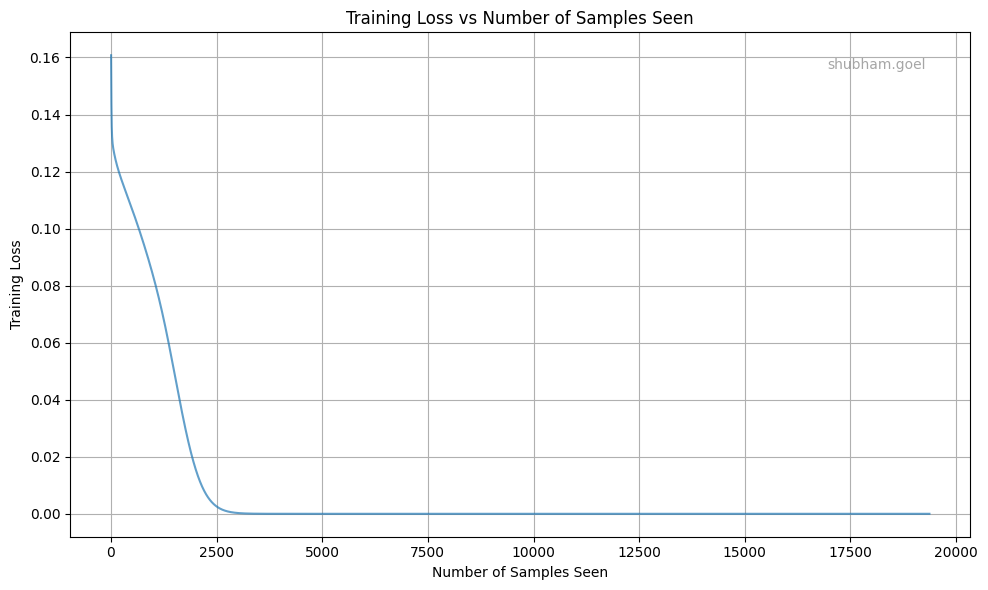

Test 3: {'accuracy': np.float64(1.0), 'final_loss': np.float64(3.8707340022294666e-30), 'epochs': 4842, 'parameters': 13}
Starting training: sample_run
Training completed: 5000 epochs, 20000 samples
Final loss: 0.000187


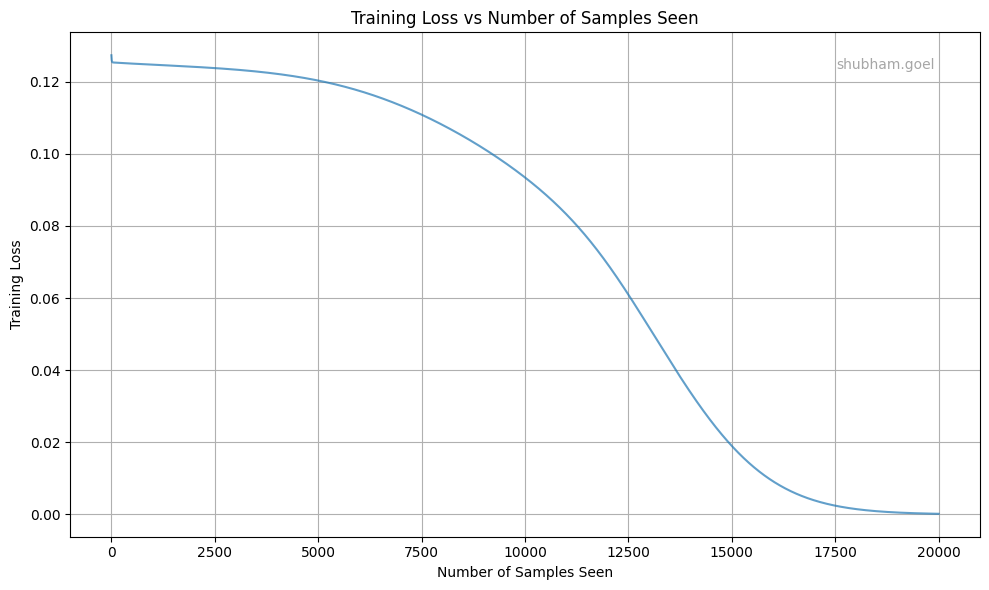

Test 4: {'accuracy': np.float64(1.0), 'final_loss': np.float64(0.00018735870598545525), 'epochs': 5000, 'parameters': 13}
Starting training: sample_run
Training completed: 5000 epochs, 20000 samples
Final loss: 0.000072


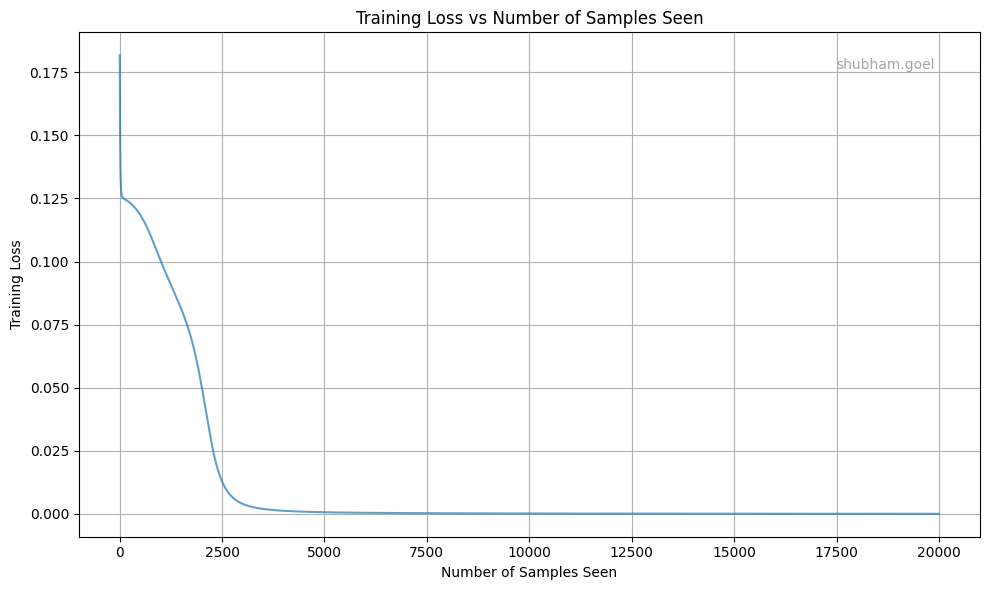

Test 5: {'accuracy': np.float64(1.0), 'final_loss': np.float64(7.159181001006502e-05), 'epochs': 5000, 'parameters': 25}


In [10]:

test_architectures = [
    ([Linear(2, 3, ReLU()), Linear(3, 1, Sigmoid())], BCELoss()),
    ([Linear(2, 3, ReLU()),Linear(3, 3, ReLU()), Linear(3, 1, Sigmoid())], BCELoss()),
    ([Linear(2, 3, Tanh()), Linear(3, 1, Identity())], MSELoss()),
    ([Linear(2, 3, Sigmoid()), Linear(3, 1, ReLU())], MSELoss()),
    ([Linear(2, 3, Identity()), Linear(3, 3, Tanh()), Linear(3, 1, Tanh())], MSELoss()),
]

for i, (layers, loss_fn) in enumerate(test_architectures):
    result = test_xor_with_arch(layers, loss_fn, learning_rate=0.5)
    print(f"Test {i+1}: {result}")




## Gradient Verification


In [ ]:
def numerical_gradient(model, x, y, param_layer_idx, param_type, param_idx, epsilon=1e-5):
    """
    Compute numerical gradient for a specific parameter using finite differences.
    This function accounts for batch size averaging to match the Linear layer implementation.
    
    Args:
        model (Model): The model to test
        x (np.ndarray): Input data
        y (np.ndarray): Target data
        param_layer_idx (int): Index of the layer containing the parameter
        param_type (str): 'weights' or 'biases'
        param_idx (tuple): Index of the specific parameter
        epsilon (float): Small value for finite difference
    
    Returns:
        float: Numerical gradient (averaged by batch size)
    """
    # Get the parameter
    layer = model.layers[param_layer_idx]
    if param_type == 'weights':
        param = layer.weights
    else:
        param = layer.biases
    
    # Store original value
    original_value = param[param_idx]
    
    # Compute loss with parameter + epsilon
    param[param_idx] = original_value + epsilon
    loss_plus = model.loss_function.forward(model.predict(x), y)
    
    # Compute loss with parameter - epsilon  
    param[param_idx] = original_value - epsilon
    loss_minus = model.loss_function.forward(model.predict(x), y)
    
    # Restore original value
    param[param_idx] = original_value
    
    # Compute numerical gradient
    numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
    
    # Average by batch size to match Linear layer implementation
    batch_size = x.shape[0]
    numerical_grad = numerical_grad / batch_size
    
    return numerical_grad


def verify_gradients(model, x, y, epsilon=1e-5, tolerance=1e-7):
    """
    Verify that backpropagation gradients match numerical gradients for every parameter.
    Uses relative difference checking for better numerical stability.
    Returns the number of parameters with incorrect gradients.
    """
    
    # Clear gradients
    model.zero_grad()
    
    # Compute analytical gradients via backpropagation
    model.train(x, y)
    
    wrong_count = 0  # Counter for parameters with wrong gradients
    different = []

    # Check gradients for each layer
    for layer_idx, layer in enumerate(model.layers):
       
        # Check ALL weight gradients
        weight_shape = layer.weights.shape
        for weight_idx in np.ndindex(weight_shape):
            # Numerical gradient
            numerical_grad = numerical_gradient(model, x, y, layer_idx, 'weights', weight_idx, epsilon)
            
            # Analytical gradient
            analytical_grad = layer.weight_gradients[weight_idx]
            
            # Calculate relative difference
            numerator = numerical_grad - analytical_grad
            denominator = numerical_grad + analytical_grad
            
            # Avoid division by zero - if both gradients are very small, consider them equal
            if denominator < 1e-12:
                relative_difference = 0.0
            else:
                relative_difference = numerator / denominator
            
            if relative_difference >= tolerance:
                wrong_count += 1
                different.append((numerical_grad, analytical_grad))
        


        # Check ALL bias gradients
        bias_shape = layer.biases.shape
        for bias_idx in np.ndindex(bias_shape):
            # Numerical gradient
            numerical_grad = numerical_gradient(model, x, y, layer_idx, 'biases', bias_idx, epsilon)
            
            # Analytical gradient
            analytical_grad = layer.bias_gradients[bias_idx]
            
            # Calculate relative difference
            numerator = numerical_grad - analytical_grad
            denominator = numerical_grad + analytical_grad
            
            # Avoid division by zero - if both gradients are very small, consider them equal
            if denominator < 1e-12:
                relative_difference = 0.0
            else:
                relative_difference = numerator / denominator
            
            if relative_difference >= tolerance:
                wrong_count += 1
                different.append((numerical_grad, analytical_grad))
    
    if len(different) > 0: print(different)
    return wrong_count  # Return total number of wrong gradients

In [12]:
test_architectures = [
    ([Linear(2, 3, ReLU()), Linear(3, 1, Sigmoid())], BCELoss()),
    ([Linear(2, 3, ReLU()),Linear(3,3,ReLU()) ,Linear(3, 1, Sigmoid())], BCELoss()),
    ([Linear(2, 3, Tanh()), Linear(3, 1, Identity())], MSELoss()),
    ([Linear(2, 3, Sigmoid()), Linear(3, 1, ReLU())], MSELoss()),
    ([Linear(2, 3, Identity()), Linear(3, 3, Tanh()), Linear(3, 1, Tanh())], MSELoss()),
]

# Use XOR dataset for gradient check
xor_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
xor_labels = np.array([[0], [1], [1], [0]], dtype=float)


# Only print wrong count for each architecture
for i, (layers, loss_fn) in enumerate(test_architectures):
    model = Model(layers, loss_fn)
    wrong_count = verify_gradients(model, xor_data, xor_labels, epsilon=1e-6, tolerance=1e-7)
    print(f"wrong count for model {i+1}: {wrong_count}")

wrong count for model 1: 0
wrong count for model 2: 0
wrong count for model 3: 0
wrong count for model 4: 0
wrong count for model 5: 0
